In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

from Engine.GlobalClock import GlobalClock, Agent
from Engine.State import State
from Engine.Aircraft import AircraftType
from Engine.FlightPlan import FlightPlan
from Engine.MultiRotorController import MultiRotorController
from Engine.Wind import WindField
from Engine.Sensors import NavUpdate, GPSPosNavUpdate
from Engine.DragModel import DragModel

import time

In [2]:
# Initialize GlobalClock to synchronize all agent behaviours
clock = GlobalClock(update_rate=200, stop=200, start=0)

AC1_AircraftType = AircraftType(max_cruise_spd=20)

#---------------------- HOVER --> DIRECT_P2P TEST FLIGHT PLAN -------------------------
# AC1_Wpt_Start_List = [np.array([0,0,0]), np.array([0,0,0])]
# AC1_Wpt_Start_Time = [0, 25]
# AC1_Wpt_End_List = [np.array([0,0,0]), np.array([100,100,100])]
# AC1_Wpt_End_Time = [25, 125]
# AC1_Mode_List = ['Hover', 'Direct_P2P']
# AC1_Duration_List = [25, 100]
# AC1_Leg_Spd = [0, 10]


#---------------------- DIRECT_P2P --> HOVER TEST FLIGHT PLAN -------------------------
# AC1_Wpt_Start_List = [np.array([0,0,0]), np.array([100,0,0])]
# AC1_Wpt_Start_Time = [0, 25]
# AC1_Wpt_End_List = [np.array([100,0,0]), np.array([100,0,0])]
# AC1_Wpt_End_Time = [25, 125]
# AC1_Mode_List = ['Direct_P2P', 'Hover']
# AC1_Duration_List = [25, 100]
# AC1_Leg_Spd = [20, 0]


#---------------------- DIRECT_P2P TEST FLIGHT PLAN -------------------------
# AC1_Wpt_Start_List = [np.array([0,0,0]), np.array([0,400,400]), np.array([400,400,400]), np.array([400,0,100])]
# AC1_Wpt_Start_Time = [0, 40, 80, 120]
# AC1_Wpt_End_List = [np.array([0,400,400]), np.array([400,400,400]), np.array([400,0,100]), np.array([0,0,100])]
# AC1_Wpt_End_Time = [40, 80, 120, 160]
# AC1_Mode_List = ['Direct_P2P', 'Direct_P2P', 'Direct_P2P', 'Direct_P2P']
# AC1_Duration_List = [40, 40, 40, 40]
# AC1_Leg_Spd = [10, 10, 10, 10]


#---------------------- HOVER TEST FLIGHT PLAN -------------------------
# AC1_Wpt_Start_List = [np.array([10,0,0]), np.array([10,0,0])]
# AC1_Wpt_Start_Time = [0, 100]
# AC1_Wpt_End_List = [np.array([10,0,0]), np.array([10,0,0])]
# AC1_Wpt_End_Time = [100, 200]
# AC1_Mode_List = ['Hover', 'Hover']
# AC1_Duration_List = [100, 100]
# AC1_Leg_Spd = [0, 0]


#---------------------- SPEED TEST FLIGHT PLAN -------------------------
# MAX GRDSPD --> APPROX 20 m/s
# MAX WINDSPD --> APPROX 5 m/s
# MAX AIRSPD --> APPROX 25 m/s

AC1_Wpt_Start_List = [np.array([0,0,0]), np.array([100,0,0]), np.array([300,0,0]), np.array([500,0,0])]
AC1_Wpt_Start_Time = [0, 40, 80, 120]
AC1_Wpt_End_List = [np.array([100,0,0]), np.array([300,0,0]), np.array([500,0,0]), np.array([100,0,0])]
AC1_Wpt_End_Time = [40, 80, 120, 160]
AC1_Mode_List = ['Direct_P2P', 'Direct_P2P', 'Direct_P2P', 'Direct_P2P']
AC1_Duration_List = [40, 40, 40, 40]
AC1_Leg_Spd = [20, 20, 20, 20]


AC1_FlightPlan = FlightPlan(AC1_Leg_Spd,
                            AC1_Mode_List,
                            AC1_Wpt_Start_List, AC1_Wpt_Start_Time,
                            AC1_Wpt_End_List, AC1_Wpt_End_Time, AC1_Duration_List)

AC1_PhysicsUpdateRate = 240
AC1_Controller_UpdateRate = 120
AC1_Start_Time = 0

AC1_Controller = MultiRotorController(AC1_Controller_UpdateRate, AC1_Start_Time, AC1_FlightPlan, AC1_AircraftType,
                                      wpt_tol_hor=0, wpt_tol_vert=0, wpt_tol=10)

WindUpdateRate = 5
Wind = WindField(WindUpdateRate, AC1_Start_Time, 
                 auto_x=0, auto_y=0, auto_z=0,
                 std_x=3, std_y=3, std_z=0,
                 mean_x=0, mean_y=0, mean_z=0)

AC1_DragModel = DragModel(AC1_AircraftType, disabled=False)

AC1_Ini_Pos = np.array([0,0,0])
AC1_Ini_Vel = np.array([0,0,0])
AC1_Ini_Pos_Err = np.array([0,0,0])
AC1_Ini_Vel_Err = np.array([0,0,0])
AC1_Ini_RPY = np.array([0,0,0])


AC1_State = State(AC1_PhysicsUpdateRate, AC1_Start_Time, 
                  AC1_Ini_Pos, AC1_Ini_Vel, 
                  AC1_Ini_Pos_Err, AC1_Ini_Vel_Err, 
                  Wind.get_windspd(AC1_Start_Time, AC1_Ini_Pos), AC1_AircraftType, 
                  rpy=AC1_Ini_RPY)

AC1_PosUpdateRate = 10
AC1_VelUpdateRate = 10
AC1_AccelUpdateRate = 100
AC1_AirSpdSensorUpdateRate = 100

GPS_horizontal_std = 15 # 3.5
GPS_horizontal_std = (GPS_horizontal_std)/np.sqrt(0.5*(4-np.pi))
# GPS_horizontal_std = (GPS_horizontal_std/2)/np.sqrt(0.5*(4-np.pi)) # Pls chk formular before running! 
GPS_vert_std = 15 # 3.5

AC1_Pos_Nav_Agent = GPSPosNavUpdate(AC1_PosUpdateRate, AC1_Start_Time, 
                                    0.994, 0.994, 0.994,
                                    GPS_horizontal_std, GPS_horizontal_std, GPS_vert_std,
                                    x_mean=0, y_mean=0, z_mean=0)
                                    # phase_delay=10 <-- manually set GPS phase delay during start-up (will rand if None)
AC1_Vel_Nav_Agent = NavUpdate(AC1_VelUpdateRate, AC1_Start_Time)
AC1_Accel_Nav_Agent = NavUpdate(AC1_AccelUpdateRate, AC1_Start_Time)
AC1_AirSpeedSensor = NavUpdate(AC1_AirSpdSensorUpdateRate, AC1_Start_Time)

In [3]:
AC1_FlightPlan.plan

,Leg No.,Target Speed,Mode,Starting Wpt,EDT,Ending Wpt,ETA,Duration
0,1,20,Direct_P2P,"[0, 0, 0]",0,"[100, 0, 0]",40,40
1,2,20,Direct_P2P,"[100, 0, 0]",40,"[300, 0, 0]",80,40
2,3,20,Direct_P2P,"[300, 0, 0]",80,"[500, 0, 0]",120,40
3,4,20,Direct_P2P,"[500, 0, 0]",120,"[100, 0, 0]",160,40


In [4]:
# Let's try to simulate this...

start = time.time()

while clock.time <= clock.stop:
    clock.update()
    if AC1_State.simstate == 0:
        continue
    # print(clock.time)
    AC1_State.update(clock.time, AC1_DragModel, 
                     AC1_Controller, 
                     AC1_Pos_Nav_Agent, AC1_Vel_Nav_Agent, AC1_Accel_Nav_Agent,
                     AC1_AirSpeedSensor, 
                     Wind)
    
end = time.time()
compute_time = end-start
simulated_time = AC1_State.time
speedup = simulated_time/compute_time

print('Simulation took: %.3f sec, simulated flight time: %.3f sec, total speedup: %.3f times'
      %(compute_time, simulated_time, speedup))

CHANGE FLIGHT LEG
Next Wpt is:  [300   0   0]
Hdg is:  [200   0   0]
CHANGE FLIGHT LEG
Next Wpt is:  [500   0   0]
Hdg is:  [200   0   0]
CHANGE FLIGHT LEG
Next Wpt is:  [100   0   0]
Hdg is:  [-400    0    0]
CHANGE FLIGHT LEG
Final WPT reached
Simulation took: 16.704 sec, simulated flight time: 56.885 sec, total speedup: 3.405 times


In [5]:
AC1_trajectory = AC1_State.get_trajectory();
AC1_trajectory.columns
# AC1_trajectory.head()

Index(['gt_pos', 'gt_vel', 'wind_spd', 'air_vel', 'accel', 'gt_pos_err',
       'gt_vel_err', 'gt_hor_err', 'accel_err', 'rpy', 'rpy_rate', 'rpy_accel',
       'commanded_net_force', 'controller_pos_err', 'thrust', 'time'],
      dtype='object')

In [6]:
def extract_from_df(df, key, idx):
    """Extracts single column from df contain cells with 3D point values. """
    df_len = len(df)
    return np.concatenate(df[key].to_numpy()).reshape(df_len, 3)[:,idx]

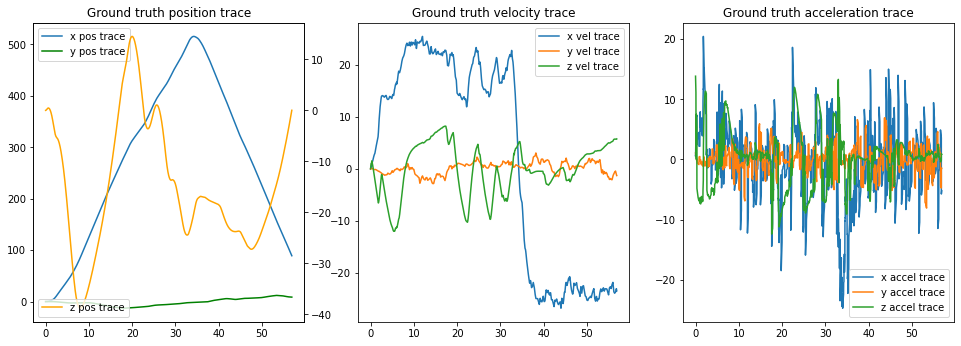

In [7]:
# Let's view ground truth position/velocity/accel

fig,axs = plt.subplots(ncols=3, figsize=(16.5,5.5))

axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_pos', 0), label='x pos trace')
axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_pos', 1), label='y pos trace', c='g')
axs2 = axs[0].twinx()
axs2.plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_pos', 2), label='z pos trace', c='orange')
axs[0].legend(loc='upper left')
axs2.legend(loc='lower left')
axs[0].set_title('Ground truth position trace')


axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_vel', 0), label='x vel trace')
axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_vel', 1), label='y vel trace')
axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_vel', 2), label='z vel trace')
axs[1].legend()
axs[1].set_title('Ground truth velocity trace')

axs[2].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'accel', 0), label='x accel trace')
axs[2].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'accel', 1), label='y accel trace')
axs[2].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'accel', 2), label='z accel trace')
axs[2].legend()
axs[2].set_title('Ground truth acceleration trace')

plt.show()

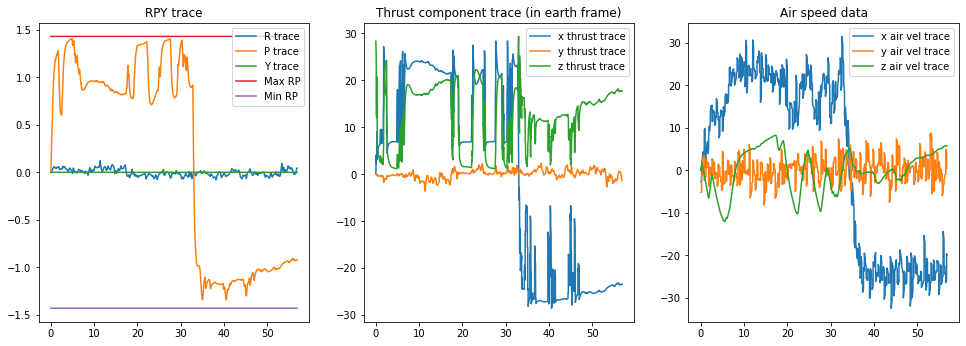

In [8]:
# Let's view ground RPY and Thrust

fig,axs = plt.subplots(ncols=3, figsize=(16.5,5.5))

axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'rpy', 0), label='R trace')
axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'rpy', 1), label='P trace')
axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'rpy', 2), label='Y trace')
max_rpy_array = np.empty(len(AC1_trajectory['time']))
max_rpy_array[:] = AC1_AircraftType.max_roll_pitch
axs[0].plot(AC1_trajectory['time'], max_rpy_array, label='Max RP')
axs[0].plot(AC1_trajectory['time'], -max_rpy_array, label='Min RP')
axs[0].legend()
axs[0].set_title('RPY trace')


axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'thrust', 0), label='x thrust trace')
axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'thrust', 1), label='y thrust trace')
axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'thrust', 2), label='z thrust trace')
axs[1].legend()
axs[1].set_title('Thrust component trace (in earth frame)')

axs[2].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'air_vel', 0), label='x air vel trace')
axs[2].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'air_vel', 1), label='y air vel trace')
axs[2].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'air_vel', 2), label='z air vel trace')
axs[2].legend()
axs[2].set_title('Air speed data')


plt.show()

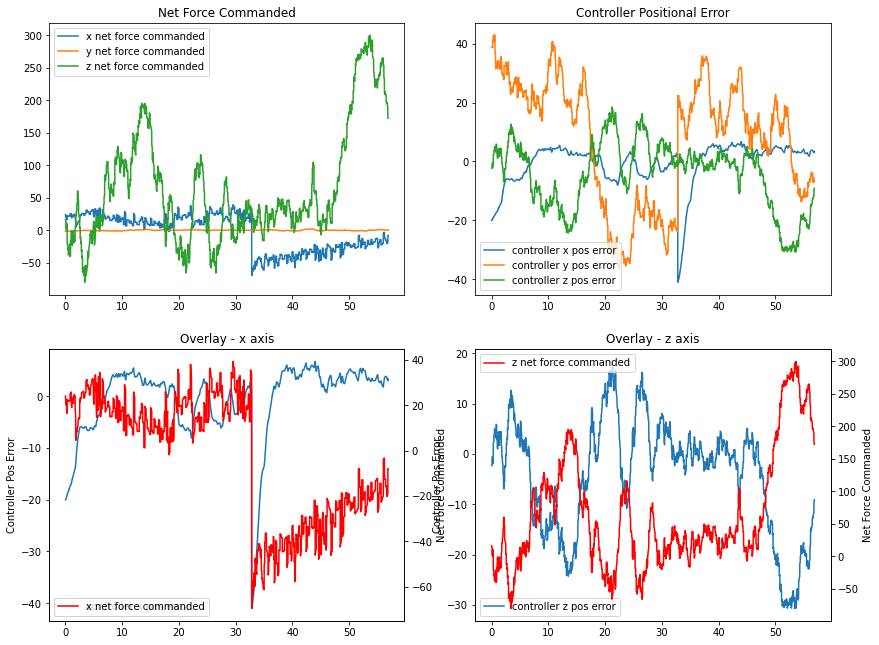

In [9]:
# Let's view ground truth controller error and commanded net force

fig,axs = plt.subplots(ncols=2, nrows=2, figsize=(14,11))

axs[0,0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'commanded_net_force', 0), label='x net force commanded')
axs[0,0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'commanded_net_force', 1), label='y net force commanded')
axs[0,0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'commanded_net_force', 2), label='z net force commanded')
axs[0,0].legend()
axs[0,0].set_title('Net Force Commanded')


axs[0,1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'controller_pos_err', 0), label='controller x pos error')
axs[0,1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'controller_pos_err', 1), label='controller y pos error')
axs[0,1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'controller_pos_err', 2), label='controller z pos error')
axs[0,1].legend()
axs[0,1].set_title('Controller Positional Error')

axs[1,0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'controller_pos_err', 0), label='controller x pos error')
axs[1,0].legend(loc = 'lower left')
axs[1,0].set_ylabel('Controller Pos Error')
axs2 = axs[1,0].twinx()
axs2.set_ylabel('Net Force Commanded')
axs2.plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'commanded_net_force', 0), label='x net force commanded', color='r')
axs2.legend()
axs[1,0].set_title('Overlay - x axis')

axs[1,1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'controller_pos_err', 2), label='controller z pos error')
axs[1,1].set_ylabel('Controller Pos Error')
axs[1,1].legend(loc = 'lower left')
axs3 = axs[1,1].twinx()
axs3.set_ylabel('Net Force Commanded')
axs3.plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'commanded_net_force', 2), label='z net force commanded', color='r')
axs3.legend()
axs[1,1].set_title('Overlay - z axis')


plt.show()

In [10]:
AC1_FlightPlan.plan.iloc[0]['Starting Wpt']

array([0, 0, 0])

NSE hor radial error std: 9.528
 x std: 11.210, y std: 22.932, z std: 13.047


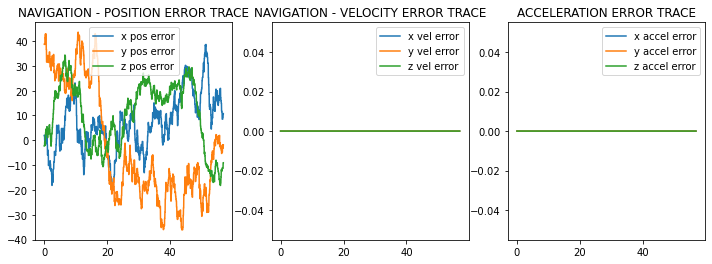

In [11]:
# Let's view NAVIGATIONAL ERRORS for position/velocity/accel

fig,axs = plt.subplots(ncols=3, figsize=(12,4))

axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_pos_err', 0), label='x pos error')
axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_pos_err', 1), label='y pos error')
axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_pos_err', 2), label='z pos error')
axs[0].legend()
axs[0].set_title('NAVIGATION - POSITION ERROR TRACE')
# axs[0].set_xlim(0,1)


axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_vel_err', 0), label='x vel error')
axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_vel_err', 1), label='y vel error')
axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_vel_err', 2), label='z vel error')
axs[1].legend()
axs[1].set_title('NAVIGATION - VELOCITY ERROR TRACE')

axs[2].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'accel_err', 0), label='x accel error')
axs[2].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'accel_err', 1), label='y accel error')
axs[2].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'accel_err', 2), label='z accel error')
axs[2].legend()
axs[2].set_title('ACCELERATION ERROR TRACE')

print('NSE hor radial error std: %.3f'%(AC1_trajectory['gt_hor_err'].std()) + 
      '\n x std: %.3f, y std: %.3f, z std: %.3f'%((extract_from_df(AC1_trajectory, 'gt_pos_err', 0).std(), 
                                                   extract_from_df(AC1_trajectory, 'gt_pos_err', 1).std(), 
                                                   extract_from_df(AC1_trajectory, 'gt_pos_err', 2).std())))

plt.show()

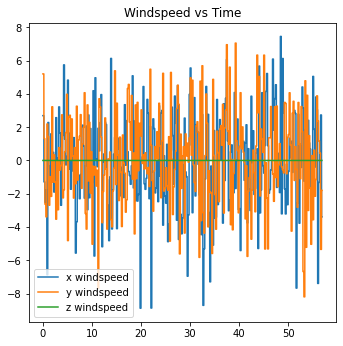

In [12]:
# Let's view WIND SPEED

fig,axs = plt.subplots(ncols=1, figsize=(5.5,5.5))

axs.plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'wind_spd', 0), label='x windspeed')
axs.plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'wind_spd', 1), label='y windspeed')
axs.plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'wind_spd', 2), label='z windspeed')
axs.legend()
axs.set_title('Windspeed vs Time')
#axs.set_xlim(0,20)

plt.show()

In [13]:
AC1_Controller.tangential_unit_vector_planar

array([-1.,  0.,  0.])

In [14]:
180*0.8/np.pi

45.83662361046586

<IPython.core.display.Javascript object>


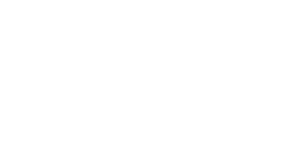

[0 0 0]
[100   0   0]
[300   0   0]
[500   0   0]
[100   0   0]


In [15]:
%matplotlib notebook

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

ax.scatter(extract_from_df(AC1_trajectory, 'gt_pos', 0), 
           extract_from_df(AC1_trajectory, 'gt_pos', 1), 
           extract_from_df(AC1_trajectory, 'gt_pos', 2), c='b')

xx, yy, zz = AC1_FlightPlan.plan.iloc[0]['Starting Wpt']
ax.scatter(xx, yy, zz, c='g')
print(AC1_FlightPlan.plan.iloc[0]['Starting Wpt'])

for wpt in AC1_FlightPlan.plan['Ending Wpt']:
    xx, yy, zz = wpt
    ax.scatter(xx, yy, zz, c='r')
    print(wpt)


    
# ax.set_xlim(-10, 510)
# ax.set_ylim(-100, 100)
# ax.set_zlim(-50,50)

plt.show()